# Project 3

Import some libraries and the datasets

In [62]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_halving_search_cv # because it is experimental we need this
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from ISLP import load_data, confusion_table
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, log_loss, mean_squared_error,confusion_matrix, classification_report,balanced_accuracy_score, max_error, PredictionErrorDisplay,mean_absolute_error, mean_absolute_percentage_error)
from sklearn.ensemble import (RandomForestRegressor, RandomForestClassifier)
from sklearn.inspection import permutation_importance
from sklearn.tree import export_graphviz
from IPython.display import Image, Markdown
import graphviz
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statistics
import re
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

In [4]:
# no idea what this is
#data_index_example = pd.read_csv('../Project_datasets/data_index - example.csv')
LPJ_GUESS_output = pd.read_csv('../Project_datasets/LPJ-GUESS_output_BERN1.csv')
# main dataset
data_index_2 = pd.read_csv('../Project_datasets/data_index_2.csv', quotechar="'")
data_index_2 = data_index_2.drop(columns=['Unnamed: 0'])
data_index_2.set_index(['Lon','Lat'])
LPJ_GUESS_output = LPJ_GUESS_output[~(data_index_2.isna().any(axis=1))] # delete rows with NaN
data_index_2 = data_index_2[~(data_index_2.isna().any(axis=1))] # delete rows with NaN
# precipitation by day and statistics
Predaymean = pd.read_csv('../Project_datasets/Predaymean1961_1990.csv')
Predaymean_statistics = pd.read_csv('../Project_datasets/Predaymean1961_1990_statics.csv')
# maximum temperature by day and statistics
Tmaxdaymean = pd.read_csv('../Project_datasets/Tmaxdaymean1961_1990.csv')
Tmaxdaymean_statistics = pd.read_csv('../Project_datasets/Tmaxdaymean1961_1990_statics.csv')
# minimum temperature by day and statistics
Tmindaymean = pd.read_csv('../Project_datasets/Tmindaymean1961_1990.csv')
Tmindaymean_statistics = pd.read_csv('../Project_datasets/Tmindaymean1961_1990_statics.csv')
# mean temperature by day and statistics
Tmpdaymean = pd.read_csv('../Project_datasets/Tmpdaymean1961_1990.csv')
Tmpdaymean_statistics = pd.read_csv('../Project_datasets/Tmpdaymean1961_1990_statics.csv')
# shortwave radiation flux
Tswrfdaymean = pd.read_csv('../Project_datasets/Tswrfdaymean1961_1990.csv')
Tswrfdaymean_statistics = pd.read_csv('../Project_datasets/Tswrfdaymean1961_1990_statics.csv')

Text file

In [5]:
gridlist_pan_gfed_ISO3_UN = open('../Project_datasets/gridlist_pan_gfed_ISO3_UN.txt','r')

Show the first entries

### Main Data set

Short legend about the colums: 

Lon: Longitude<br>
Lat: Latidude

stuff about the souil texture: <br>

clay: Clay in %<br>
silt: Silt in % (sedimentary deposit that is formed when a river deposits the material it is carrying)<br>
slay: slay in %(soil in eg. rainforest) <br>
sand: sand in % %<br>
orC: organic carbondioxid in %<br>
CN: Cyanide in %<br>
pH: pH<br>
cell fraction: portion of cells / organic material in soil in % <br>


Allways with season: Same as the tables below.

tmax: maximum temperatur in K <br>
tmin: min temperature in K <br>
tmp:mean temperature in K <br>
Pre: Precipitation, mm day-1 <br>
tswrf: Total shortwave radiation flux, W m-2


This is the GUESS output: 

NPP: net primary productivity (kg C m-2 year-1)<br>
SoilR: soil respiration (kg C m-2 year-1)<br>
MaxBiomeCmass: The maximum biomass from a single biome (kg C m-2)<br>
MxbiomeLAI: The maximum leaf area index from a single biome (unitless)<br>
VegC: Vegetation carbon poo (kg C m-2)l<br>
LitterC: Litter carbon pool (kg C m-2)<br>
SoilC: Soil carbon pool (kg C m-2)<br>
Biome_Cmass: The biome type based on the maximum biomass (category)<br>
Biome_LAI: The biome type based on the maximum LAI (category)<br>
Biome_obs: The observed biome type (category)<br>

Country codes

GFED-region: Global Fire Emissions Database (https://www.un-spider.org/global-fire-emissions-database-gfed) <br>
Pan_2007: Big reogion (Europa, Africa, Australia, USA, Russia, China, .... )<br>
ISO3: Abbreviation for country <br>
UN: Country code

In [9]:
print(f'shape: {data_index_2.shape}')
data_index_2.head()

shape: (59190, 83)


,Lon,Lat,clay,silt,sand,orgC,CN,pH,cellfraction,tmax_SpringMean,...,VegC,LitterC,SoilC,Biome_Cmax,Biome_LAI,Biome_obs,GFED-region,Pan_2007,ISO3,UN
0,-179.75,71.25,0.08,0.37,0.55,0.020,11.0,5.9,0.482,249.88,...,0.0,0.000,0.000,13,13,17,10,Russia,RUS,643
1,-179.75,68.75,0.20,0.48,0.32,0.031,17.0,6.3,0.753,250.64,...,0.0,0.003,0.015,13,11,17,10,Russia,RUS,643
2,-179.75,68.25,0.20,0.48,0.32,0.031,17.0,6.3,0.447,249.84,...,0.0,0.006,0.022,13,11,17,10,Russia,RUS,643
3,-179.75,67.75,0.20,0.48,0.32,0.031,17.0,6.3,0.526,250.84,...,0.0,0.002,0.020,13,11,17,10,Russia,RUS,643
4,-179.75,67.25,0.20,0.48,0.32,0.031,17.0,6.3,0.422,251.42,...,0.0,0.003,0.016,13,11,17,10,Russia,RUS,643


In [10]:
with open("../Project_datasets/Readme.txt",'r') as script:
    speech = script.read().splitlines()

count = 1
for line in speech:
    if False:
        count+=1
        if count % 2 == 0: #this is the remainder operator
            print(line)
    else:
        print(line)

data information:
1. There are five climate variables which are daily average values during 1961-1990. They are Tswrf (Total shortwave radiation flux, W m-2), Pre (Precipitation, mm day-1), Tmp (Daily mean temperature, K), 
Tmax (Daily maximum temperature, K), and Tmin (Daily minimum temperature, K). 

2. In the file LPJ-GUESS_output BERN1.csv, the following variables are collected:
NPP: net primary productivity (kg C m-2 year-1)
SoilR: soil respiration (kg C m-2 year-1)
MaxBiomeCmass: The maximum biomass from a single biome (kg C m-2)
MxbiomeLAI: The maximum leaf area index from a single biome (unitless)
VegC: Vegetation carbon poo (kg C m-2)l
LitterC: Litter carbon pool (kg C m-2)
SoilC: Soil carbon pool (kg C m-2)
Biome_Cmass: The biome type based on the maximum biomass (category)
Biome_LAI: The biome type based on the maximum LAI (category)
Biome_obs: The observed biome type (category)

3. legend of biome

4. soilmap_center_interpolated.dat: the texture inforamtion for each grid ce

### LPJ_Guess_output


In [11]:
print(f'shape: {LPJ_GUESS_output.shape}')
LPJ_GUESS_output.head()

shape: (59190, 12)


,Lon,Lat,NPP,SoilR,MaxBiomeCmax,MaxBiomeLAI,VegC,LitterC,SoilC,Biome_Cmax,Biome_LAI,Biome_obs
0,39.75,-1.25,0.429,0.390,0.449,1.9821,1.225,0.758,5.941,8,12,12
1,150.25,-34.25,0.554,0.451,6.883,3.3174,6.953,3.221,10.566,7,7,6
2,-63.75,82.75,0.000,0.000,0.000,0.0000,0.000,0.003,0.002,13,13,17
3,59.25,30.75,0.043,0.042,0.090,0.2146,0.127,0.084,0.543,7,11,14
4,24.25,27.75,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,13,13,17


### Pred (Precipitation, mm day-1)
 

In [12]:
print(f'shape: {Predaymean.shape}')
#Predaymean.head()

shape: (59191, 367)


In [13]:
print(f'shape: {Predaymean_statistics.shape}')
#Predaymean_statistics.head()

shape: (59191, 14)


### Tmp (Daily mean temperature, K)

In [14]:
print(f'shape: {Tmpdaymean.shape}')
#Tmpdaymean.head()

shape: (59191, 367)


In [15]:
print(f'shape: {Tmpdaymean_statistics.shape}')
#Tmpdaymean_statistics.head()

shape: (59191, 14)


### Tmax

In [16]:
print(f'shape: {Tmaxdaymean.shape}')
#Tmaxdaymean.head()

shape: (59191, 367)


In [17]:
print(f'shape: {Tmaxdaymean_statistics.shape}')
#Tmaxdaymean_statistics.head()

shape: (59191, 14)


### Tmin

In [18]:
print(f'shape: {Tmindaymean.shape}')
#Tmindaymean.head()

shape: (59191, 367)


In [19]:
print(f'shape: {Tmindaymean_statistics.shape}')
#Tmindaymean_statistics.head()

shape: (59191, 14)


### Tswrf (Total shortwave radiation flux, W m-2)

In [20]:
print(f'shape: {Tswrfdaymean.shape}')
#Tswrfdaymean.head()

shape: (59191, 367)


In [21]:
print(f'shape: {Tswrfdaymean_statistics.shape}')
#Tswrfdaymean_statistics.head()

shape: (59191, 14)


### County List and binome legend

In [22]:
# Read the data from file into a list-of-lists table.
with open('../Project_datasets/gridlist_pan_gfed_ISO3_UN.txt') as file:
    datatable = [line.split() for line in file.read().splitlines()]

country_codes = pd.DataFrame(datatable, columns = ['Lon', 'Lat', 'GFED-region', 'Pan_2007', 'ISO3', 'UN'] )  
country_codes = country_codes.drop(index = 0)
country_codes.head()

,Lon,Lat,GFED-region,Pan_2007,ISO3,UN
1,-69.75,-55.25,5,Americas,CHL,152
2,-69.25,-55.25,5,Americas,CHL,152
3,-71.25,-54.75,5,Americas,CHL,152
4,-70.75,-54.75,5,Americas,CHL,152
5,-70.25,-54.75,5,Americas,CHL,152


In [23]:
    
with open("../Project_datasets/legend of biomes.txt",'r') as script:
    speech = script.read().splitlines()

count = 1
for line in speech:
    if True:
        count+=1
        if count % 2 == 0: #this is the remainder operator
            print(line)
    else:
        print(line)

1 Boreal decid forest
2 Boreal ever forest
3 Temp/boreal mix fo.
4 Temp conifer forest
5 Temp decid forest
6 Temp broad ever fo.
7 Temp mixed forest
8 Trop season forest
9 Trop rain forest
10 Trop decid forest
11 Moist savannas
12 Dry savannas
13 Tall grassland
14 Dry grassland
15 Xeric wood/shrub
16 Arid shrub/steppe
17 Desert
18 Arctic/alpine tundra


## Some preparations

### number of samples of different biomes in different coutries

In [24]:
countrys_sample_size = data_index_2.groupby(['ISO3', 'Biome_obs']).size()   ##### NOT TESTED
#countrys_sample_size = pd.DataFrame(countrys_sample_size)
#countrys_sample_size.columns = [ "Size"]           # Maybe solve later
countrys_sample_size.head()

ISO3  Biome_obs
AGO   6              3
      8            187
      9             25
      10            88
      11             7
dtype: int64

In [25]:
# Samply size for countries
countrys_sample_size.at["EGY"]

Biome_obs
14     34
16     34
17    292
dtype: int64

### Plot and table generation

In [26]:
# Names my have to be improved
def df_to_latex(df, filename = 'mytable'):  
    s = df.style.to_latex(
    column_format="rrrrr", position="h", position_float="centering",
    hrules=True, label="table:5",
    multirow_align="t", multicol_align="r"
    )  
        
    with open('../Table/' + filename + '.tex', 'w') as f:
        f.write(s)  
    

In [27]:
## test
df = pd.DataFrame(dict(name=['Raphael', 'Donatello'],
                       age=[26, 45],
                       height=[181.23, 177.65]))

df_to_latex(df, filename = 'ATable')

In [28]:
def save_plot(figure, figurename = 'my_plot'):
    figure.savefig('../plots/' + figurename + '.pdf', bbox_inches='tight')

## test
#save_plot(fig, figurename ='worldmap')

### Plot function for statistics

In [29]:
def plot_statistics(data, name_data = 'data'):
    
    obs_data = "Biome_obs"
    fig, ax = plt.subplots(figsize = (8,4))
    ax = sns.countplot(data, x = obs_data)
    save_plot(fig, figurename = 'countplot_' + name_data + '_' + obs_data)
    
    obs_data = "Biome_Cmax"
    fig, ax = plt.subplots(figsize = (8,4))
    ax = sns.countplot(data, x = obs_data)
    save_plot(fig, figurename = 'countplot_' + name_data + '_' + obs_data)
    
    ## sample biomes
    obs_data = "Biome_obs_Pan_2007"
    fig, ax = plt.subplots(figsize = (8,4))
    ax = sns.countplot(data, x = 'Pan_2007', hue = 'Biome_obs')
    ax.tick_params(axis='x', rotation=90)
    save_plot(fig, figurename = 'countplot_' + name_data + '_' + obs_data)
    
    ## sample biomes
    obs_data = "Biome_obs_ISO3"
    fig, ax = plt.subplots(figsize = (8,4))
    ax = sns.countplot(data, x = 'ISO3', hue = 'Biome_obs')
    ax.tick_params(axis='x', rotation=90)
    save_plot(fig, figurename = 'countplot_' + name_data + '_' + obs_data)
    
    ## scatterplot biome_Cmax and biome_LAI
    obs_data = "Biome_obs_Biome_Cmax"
    fig, ax = plt.subplots(figsize = (4,4))
    ax = sns.scatterplot(data, x = "Biome_Cmax", y = "Biome_obs")
    ax.set_yticks(range(1, 20,2))
    save_plot(fig, figurename = 'scatterplot_' + name_data + '_' + obs_data)
    
    '''
    obs_data = "Biome_obs_Biome_LAI"
    fig, ax = plt.subplots(figsize = (4,4))
    ax = sns.scatterplot(data, x = "Biome_LAI", y = "Biome_obs")
    ax.set_yticks(range(1, 20,2))
    save_plot(fig, figurename = 'scatterplot_' + name_data + '_' + obs_data)
    '''
    
    # NPP
    obs_data = "NPP"
    fig, axs = plt.subplots( 1,2, constrained_layout=True)
    sns.histplot(data, x=obs_data,  kde=True, ax=axs[0]) #stat="density", kde=True,, log_scale=True
    sns.ecdfplot(data, x="NPP", ax=axs[1])
    save_plot(fig, figurename = 'histogramm_' + name_data + '_' + obs_data)
    
    #"VegC"
    obs_data = "VegC"
    fig, axs = plt.subplots(1,2, constrained_layout=True)
    sns.histplot(data, x=obs_data,   kde=True, ax=axs[0]) #stat="density", kde=True,binwidth=1,
    sns.ecdfplot(data, x="VegC", ax=axs[1])
    save_plot(fig, figurename = 'histogramm_' + name_data + '_' + obs_data)

## Section 2: Visualisation


In [30]:
weather_params = ['pre','tmp|tmin|tmax','tswrf']

features_weather = [feature_name for feature_name in list(data_index_2) if \
                   re.search('Fall|Summer|Winter|Spring',feature_name)]

liste = ['Lat', 'Lon', 'UN', 'GFED-region', 'Biome_obs', 'Biome_LAI', 'Biome_Cmax']+features_weather

print(data_index_2.drop(liste, axis=1).describe())

               clay          silt          sand          orgC            CN  \
count  59190.000000  59190.000000  59190.000000  59190.000000  59190.000000   
mean       0.226426      0.280913      0.492661      0.022554     12.038250   
std        0.106557      0.109771      0.165725      0.056029      2.444517   
min        0.040000      0.050000      0.170000      0.002000      9.000000   
25%        0.170000      0.200000      0.380000      0.007000     11.000000   
50%        0.230000      0.300000      0.450000      0.013000     11.000000   
75%        0.270000      0.330000      0.570000      0.017000     13.000000   
max        0.540000      0.610000      0.900000      0.384000     23.000000   

                 pH  cellfraction           NPP         SoilR  MaxBiomeCmax  \
count  59190.000000  59190.000000  59190.000000  59190.000000  59190.000000   
mean       6.329958      0.520901      0.406856      0.347518      3.738406   
std        1.188566      0.167647      0.311654    

Countplot to count the number of data for each biom: 

In [45]:
#sns.scatterplot(data_index_2, x="Lon", y="Lat", hue="Biome_obs")

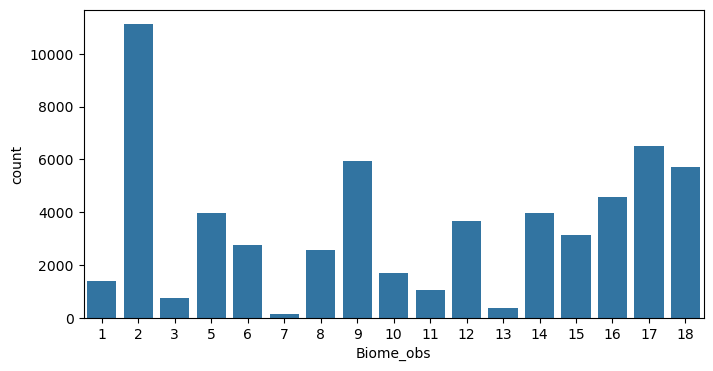

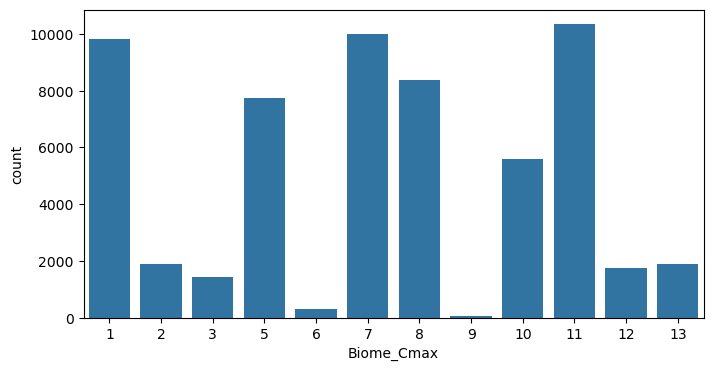

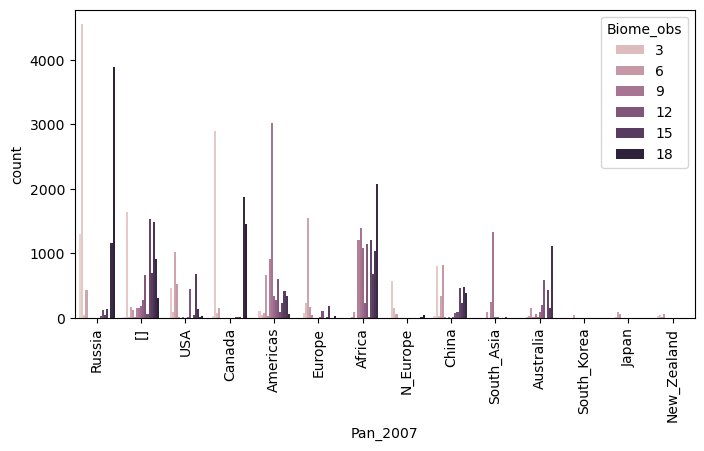

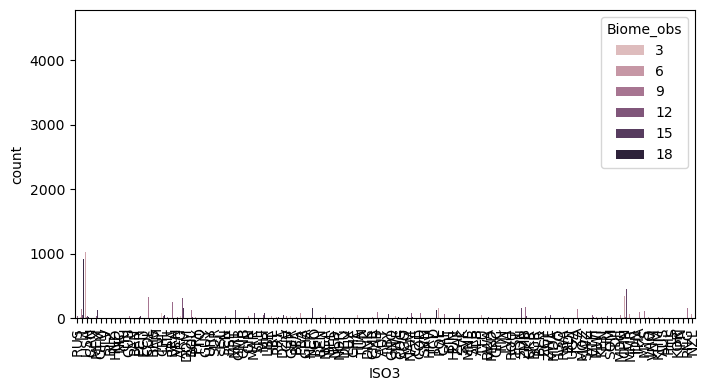

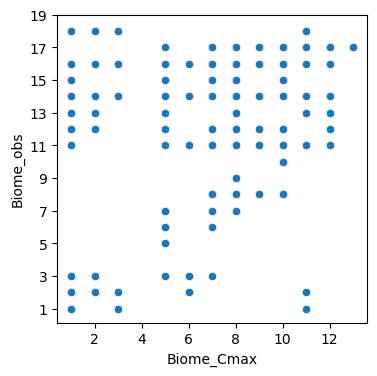

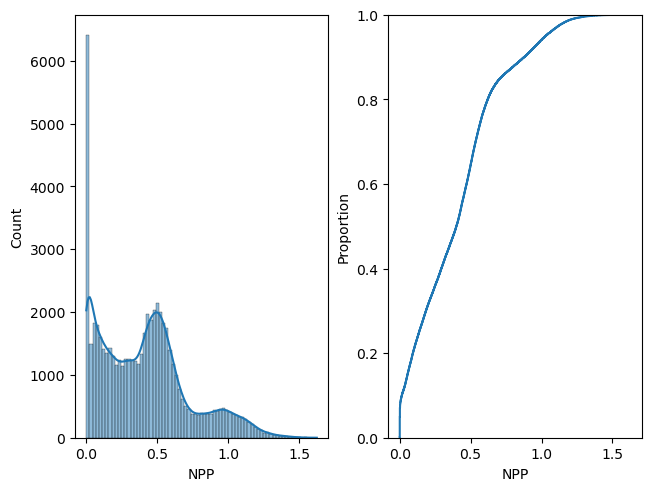

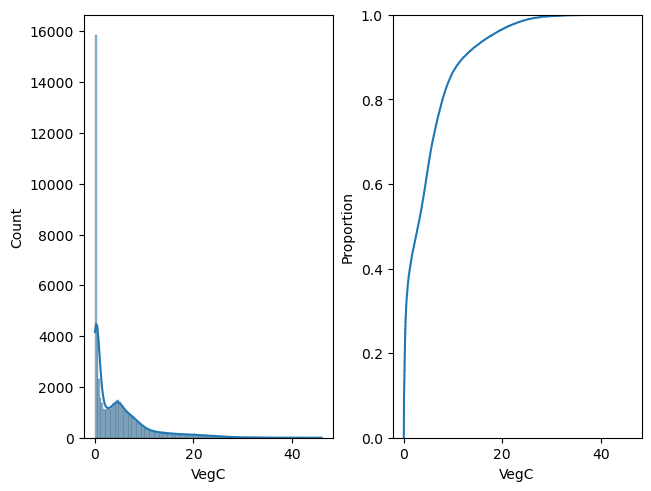

In [46]:
plot_statistics(data_index_2)

Biome with index 4?

In [47]:
data_index_2.loc[data_index_2['Biome_obs'] == 4]

,Lon,Lat,clay,silt,sand,orgC,CN,pH,cellfraction,tmax_SpringMean,...,VegC,LitterC,SoilC,Biome_Cmax,Biome_LAI,Biome_obs,GFED-region,Pan_2007,ISO3,UN


# Functions for Classifiaction and Regression

### Generate test and train sets

In [63]:
# the following function generates X_test, Y_test and X_train, Y_train for the binary classification
def model_create_XY(region_train, region_test, \
                     drop_columns=[], use_columns=None, \
                        objective='Biome_obs', objective_list=None, continuous_Y=False,
                        objective_test=None):
      
      drop_columns = drop_columns.copy() + [objective] # we would not want our objective to appear in the training data
      if not objective_test: objective_test = objective

      # restrict to two biomes, restrict to country codes, remove any rows with NaN
      if not continuous_Y:
            if not objective_list: objective_list=list(data_index_2.loc[region_train][objective].drop_duplicates())
            relevant_data_train = data_index_2.loc[data_index_2[objective].isin(objective_list)] # restrict to given biomes
            # in case we want to use LPJ_guess output, write LPJ_ before the objective_list
            if re.search('LPJ_',objective_test):
                  objective_test = objective_test[4:]
                  relevant_data_test = data_index_2.loc[LPJ_GUESS_output[objective_test].isin(objective_list)] # restrict to given biomes
                  relevant_data_test[objective_test] = LPJ_GUESS_output.loc[LPJ_GUESS_output[objective_test].isin(objective_list)][objective_test] # restrict to given biomes
            else:
                  relevant_data_test = data_index_2.loc[data_index_2[objective_test].isin(objective_list)] # restrict to given biomes
      else:
            relevant_data_train = data_index_2
            relevant_data_test = data_index_2
            if re.search('LPJ_',objective_test):
                  objective_test = objective_test[4:]
                  relevant_data_test[objective_test] = LPJ_GUESS_output[objective_test]

                  
      relevant_data_train = relevant_data_train.loc[region_train] # restrict to training country
      relevant_data_test = relevant_data_test.loc[region_test] # restrict to test country

      drop_columns += ['MaxBiomeLAI','Biome_obs','Biome_LAI','Biome_Cmax',
                       'Lon','Lat','Pan_2007','ISO3','UN','MaxBiomeCmax'] # drop these columns
      if use_columns:
            X_train = relevant_data_train[use_columns]
            X_test = relevant_data_test[use_columns]
      else:
            X_train = relevant_data_train.drop(columns=drop_columns)
            X_test = relevant_data_test.drop(columns=drop_columns)

      feature_names = list(X_train.columns)

      Y_train = relevant_data_train[objective]
      Y_test = relevant_data_test[objective_test]

      print(f"length of training data: {Y_train.shape[0]}")
      print(f"length of testing data: {Y_test.shape[0]}")
      

      return X_train, X_test, Y_train, Y_test, feature_names

### Plot Feature importance (Permutation importance vs. purity importance)

Important Notes
- The more accurate model is, the more trustworthy computed importances are.
- The computed importances describe how important features are for the machine learning model. It is an approximation of how important features are in the data.


In [88]:
def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=2)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

def plot_permutation_importance_big_graph(clf, X_train, Y_train, feature_imp):

    mdi_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
    # tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
    # tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
    mdi_importances.sort_values().plot.barh(ax=ax1)
    ax1.set_xlabel("Gini importance")
    plot_permutation_importance(clf, X_train, Y_train, ax2)
    ax2.set_xlabel("Decrease in accuracy score")
    fig.suptitle(
        "Impurity-based vs. permutation importances on multicollinear features (train set)"
    )
    _ = fig.tight_layout()
    return fig

def clustering(clf, X):
    fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))
    corr = spearmanr(X).correlation

    # Ensure the correlation matrix is symmetric
    corr = (corr + corr.T) / 2
    np.fill_diagonal(corr, 1)

    # We convert the correlation matrix to a distance matrix before performing
    # hierarchical clustering using Ward's linkage.
    distance_matrix = 1 - np.abs(corr)
    dist_linkage = hierarchy.ward(squareform(distance_matrix))
    dendro = hierarchy.dendrogram(
        dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
    )
    dendro_idx = np.arange(0, len(dendro["ivl"]))

    ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
    ax2.set_xticks(dendro_idx)
    ax2.set_yticks(dendro_idx)
    ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
    ax2.set_yticklabels(dendro["ivl"])
    _ = fig.tight_layout()

### Clasification

In [89]:
# the following generates, trains and evaluates the model
def model_train_evaluate(X_train, X_test, Y_train, Y_test, feature_names, \
                         hyperparameter_tuning=False):

    clf = RandomForestClassifier(random_state=0)
    
    if hyperparameter_tuning==4: # for testing parameters manually
        clf = RandomForestClassifier(random_state=0, max_depth=10, n_estimators=100, min_samples_leaf=1)
    elif hyperparameter_tuning:
        X_hyper, Y_hyper = X_train, Y_train
        # X_hyper,_,Y_hyper,_ = skm.train_test_split(X_train, Y_train, train_size=300,random_state=0)
        # TODO: improve on this
        kfold3 = skm.KFold(3,
                        random_state=1,
                        shuffle=True) # let's try fewer fold to save running time

        fineness = 4 # determines how many parameters should be tested
        params = {
                'max_depth': np.linspace(5, 15, fineness).astype('int'), # (5,15)
                'n_estimators': np.linspace(50, 150, fineness).astype('int'), # (10,40) CV number of trees, keep this low for part 4
                'min_samples_leaf': np.linspace(1, 5, fineness).astype('int'), # minimum leaf number
                }
        if False:
            rfc_gscv = GridSearchCV(clf, param_grid = params, scoring = "accuracy",
                                        cv = kfold3 )
        else:
            # Alternatively use HalvingGridSearchCV which is equally abismal in its performance
            rfc_gscv = HalvingGridSearchCV(clf, param_grid = params, scoring = "accuracy",
                                        cv = kfold3, min_resources=20, max_resources=30)
        
        # Fit the model
        model_rfc = rfc_gscv.fit(X_hyper, Y_hyper)

        # Model best estimator
        max_depths=model_rfc.best_estimator_.get_params()["max_depth"]
        max_trees= model_rfc.best_estimator_.get_params()["n_estimators"]
        min_samples_leaf= model_rfc.best_estimator_.get_params()["min_samples_leaf"]
        max_cvs= rfc_gscv.best_score_
        print("Max Depth: ", max_depths)
        print("Max Trees: ",max_trees)
        print("Min Leafs: ",min_samples_leaf)
        print("Max CV: ",max_cvs)

        clf = RandomForestClassifier(random_state=0, max_depth=max_depths, n_estimators=max_trees, min_samples_leaf=min_samples_leaf)

    clf.fit(X_train, Y_train)


    # Some performance 
    score_rfc_train = accuracy_score(Y_train, clf.predict(X_train))
    print('Accuracy of RandomForestClassifier on train data: {:.4f}'.format(score_rfc_train))
    balance_score_rfc_train = balanced_accuracy_score(Y_train, clf.predict(X_train))
    print('Balanced accuracy of RandomForestClassifier on train data: {:.4f}'.format(balance_score_rfc_train))
    
    kfold = skm.KFold(3, random_state=1, shuffle=True)
    # This becomes computationally quite expensive for large training sets
    scores_rfc_val = cross_val_score(clf, X_train, Y_train, cv=kfold)
    print("Accuracy RandomForestClassifier on cross validation: %0.4f ( %0.2f)" % (scores_rfc_val.mean(), scores_rfc_val.std()))

    score_rfc_test = accuracy_score(Y_test, clf.predict(X_test))
    print('Accuracy of RandomForestClassifier on test data: {:.4f}'.format(score_rfc_test))
    balance_score_rfc_test = balanced_accuracy_score(Y_test, clf.predict(X_test))
    print('Balanced accuracy of RandomForestClassifier on train data: {:.4f}'.format(balance_score_rfc_test))
    
    # confusion table
    display(Markdown('---\n The confusion table'))
    display(confusion_table(clf.predict(X_test),
                            Y_test))
    
    classreport = classification_report(Y_test, clf.predict(X_test), zero_division = np.nan, output_dict=True)
    classreport = pd.DataFrame(classreport).transpose()
    display(classreport)
    
    # display importance table
    display(Markdown('---\n The feature importance'))
    feature_impo = clf.feature_importances_
    feature_imp = pd.DataFrame(
    {'importance':clf.feature_importances_},
    index=feature_names)
    display(feature_imp.sort_values(by='importance', ascending=False))
    
    
    # Plot Impurity-based vs. Permutation importance
    #plot_permutation_importance_big_graph(clf, X_train, Y_train, feature_imp)
    
    clustering(clf, X_train)
    
    display(Markdown('---'))

### Regression

In [90]:
def regression_train_evaluate(X_train, X_test, Y_train, Y_test, feature_names, \
                         hyperparameter_tuning=False):
    reg = RandomForestRegressor()
    reg.fit(X_train, Y_train)

    score_reg_train = reg.score(X_train, Y_train)
    #Return the coefficient of determination of the prediction (R^2 score)
    
    print('Accuracy of RandomForestRegressor on train data: {:.4f}'.format(score_reg_train))
    # The following takes way to long for large training sets
    # kfold = skm.KFold(3, random_state=1, shuffle=True)
    # scores_reg_val = cross_val_score(reg, X_train, Y_train, cv=kfold)
    # print("Accuracy RandomForestRegressor on cross validation: %0.4f ( %0.2f)" % (scores_reg_val.mean(), scores_reg_val.std()))
    score_reg_test = reg.score(X_test, Y_test)
    print('Accuracy of RandomForestRegressor on test data: {:.4f}'.format(score_reg_test))

    # MSE
    Y_hat = reg.predict(X_test)
    mse = np.mean((Y_test - Y_hat)**2)
    print(f'MSE for training data {mse}')

    mse2 = mean_squared_error(Y_test,Y_hat)
    print(f'MSE (with sktfct) for test  data {mse2}')

    # SQRT(MSE)
    sqrtmse = np.sqrt(mse)
    print(f'sqrt(MSE) for test data {sqrtmse}')

    # maximum Error
    max_err = max_error(Y_test, Y_hat)
    print(f'max error for test data {max_err}')

    # mean absolute error
    mean_abs_err = mean_absolute_error(Y_test, Y_hat)
    print(f'mean abs error for test data {mean_abs_err}')

    #PredictionErrorDisplay(Y_test, Y_hat)
    
    
    
    fig, ax = subplots()
    ax.scatter(Y_hat, Y_test)
    ax.set_xlabel('predicted sample $\hat{Y}$')
    ax.set_ylabel('exact sample $Y_{test}$')
    maxval = max([np.max(Y_test),np.max(Y_hat)])
    ax.plot([0,maxval],[0,maxval],color='red')

    fig, ax = plt.subplots()
    ax.hist(Y_test-Y_hat, bins=50, density=True)
    ax.set_xlabel('residue $Y_{test}-\hat{Y}$')
    ax.set_ylabel('Share of samples')
    

about R2 score - which is the accuracz in the regression case: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score

In cases where negative values arise, the mean of the data provides a better fit to the outcomes than do the fitted function values, according to this particular criterion. (Wikipedia: https://en.wikipedia.org/wiki/Coefficient_of_determination)

### Run model 
continuous_Y = True gives regression, else classification



In [72]:

# run the training data, test data and the model
def model_run(region_train, region_test, objective='Biome_obs', objective_list=None, \
                drop_columns=[], use_columns=None, \
                hyperparameter_tuning=False, continuous_Y=False, objective_test=None):
    X_train, X_test, Y_train, Y_test, feature_names = model_create_XY(region_train, \
                        region_test, drop_columns, use_columns, objective, \
                              objective_list, continuous_Y, objective_test)
    if continuous_Y:
        regression_train_evaluate(X_train, X_test, Y_train, Y_test, feature_names, \
                         hyperparameter_tuning)
    else:
        model_train_evaluate(X_train, X_test, Y_train, Y_test, feature_names, \
                         hyperparameter_tuning)

## Section 3: Binary classification

We saw that `NaN` appeard somewhere in `data_index_2`. The following is to find out where it occurs.

In [73]:
print(list(data_index_2.loc[:,data_index_2.isna().any()]))
data_index_2[data_index_2.isna().any(axis=1)]

[]


,Lon,Lat,clay,silt,sand,orgC,CN,pH,cellfraction,tmax_SpringMean,...,VegC,LitterC,SoilC,Biome_Cmax,Biome_LAI,Biome_obs,GFED-region,Pan_2007,ISO3,UN


Choose countries. Random.org gave us the biomes
- 17: desert
- 16: Arid shrub/steppe

In [74]:
biome_list_3 = [17,16] # our chosen biomes

Countplot: 

In [75]:
relevant_data = data_index_2.loc[data_index_2['Biome_obs'].isin(biome_list_3)]
relevant_data = relevant_data[~(relevant_data.isna().any(axis=1))] # delete rows with NaN

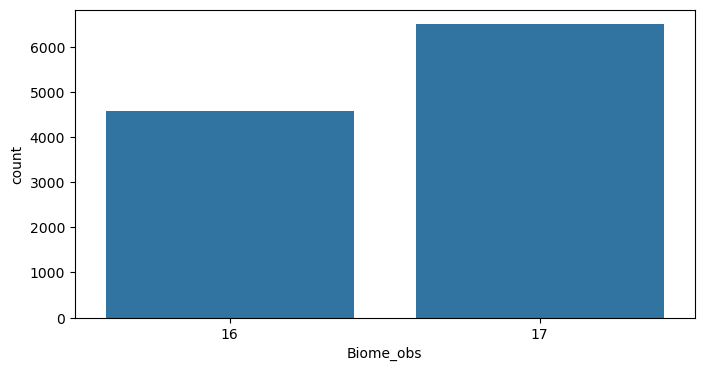

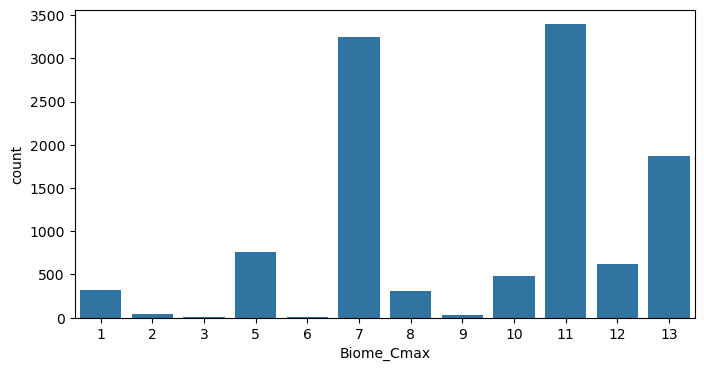

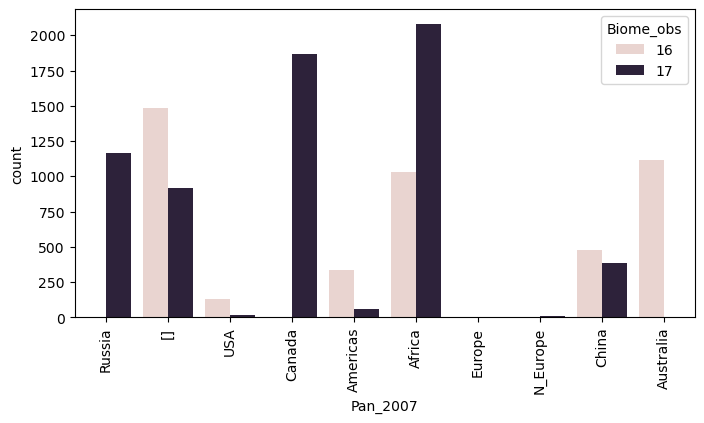

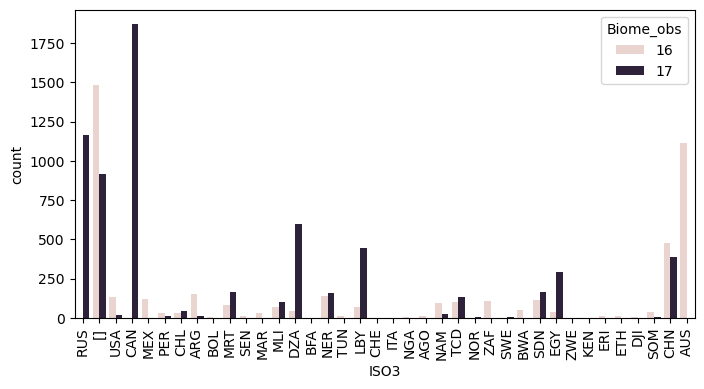

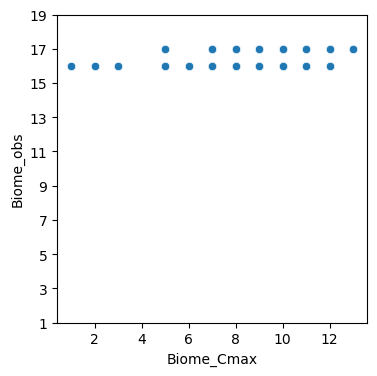

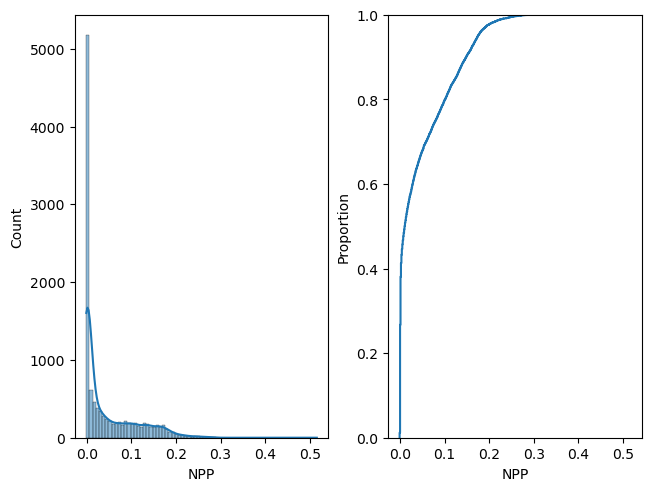

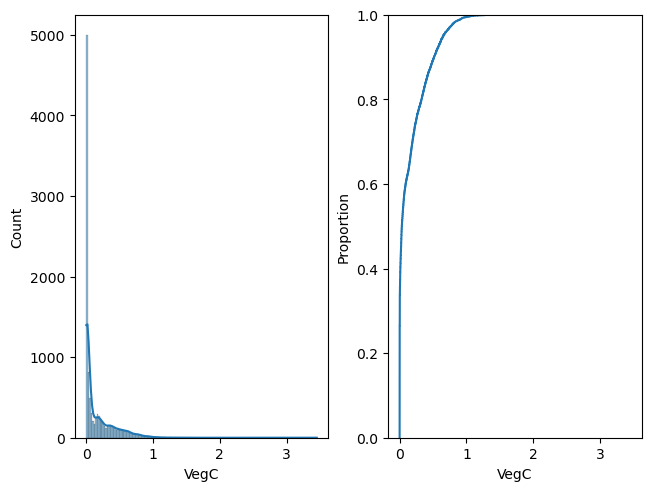

In [76]:
plot_statistics(relevant_data, name_data = 'Section3Biome17_and_16')

Thus we choose Egypt to train and China as test.

In [77]:
region_train_3 = data_index_2['ISO3'] == 'EGY' # egypt is the chosen one
region_test_3 = data_index_2['ISO3'] == 'CHN' # china is the chosen one, alternatively LBY (libya)

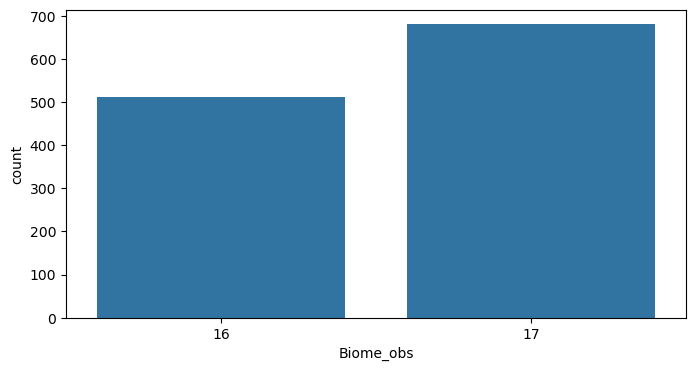

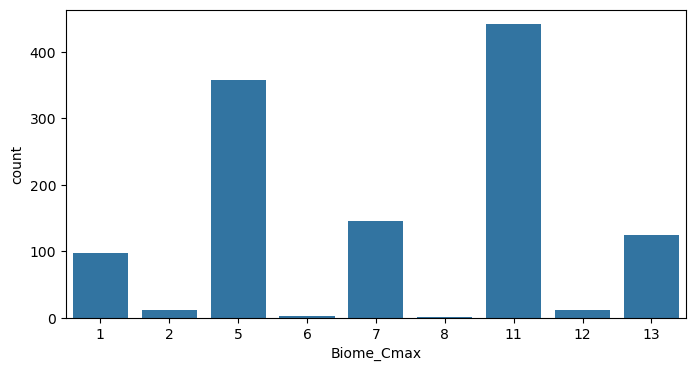

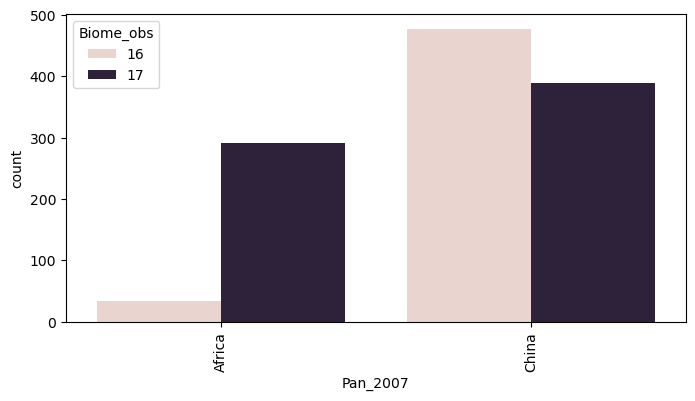

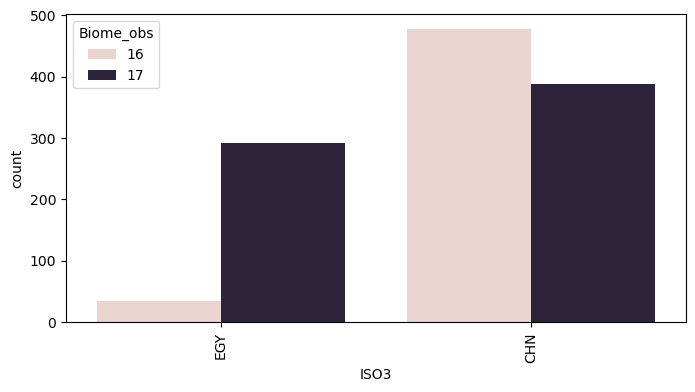

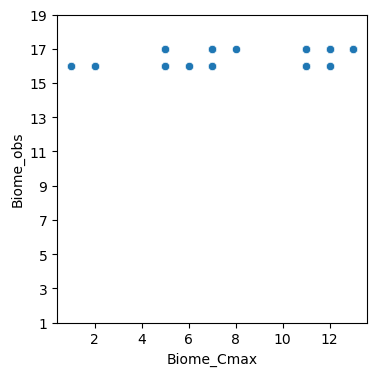

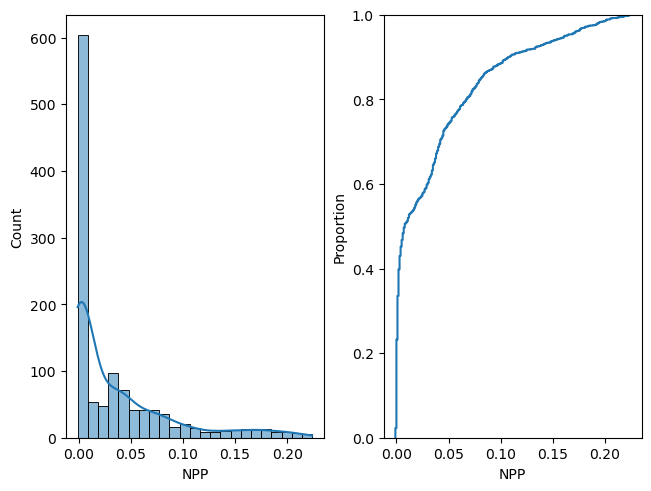

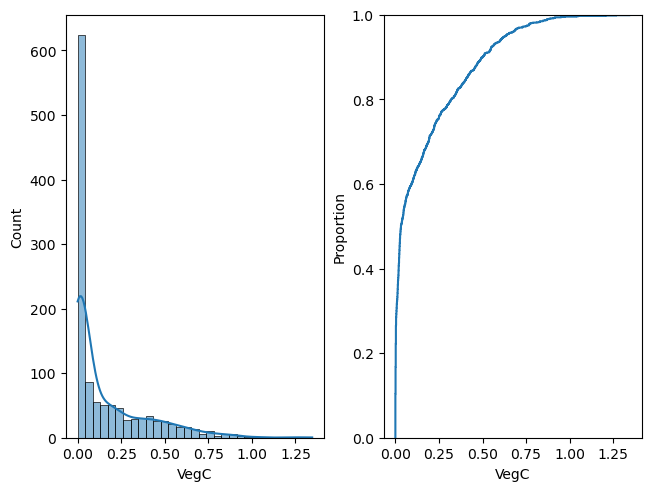

In [78]:
# plot the data
data1 = relevant_data.loc[region_train_3] 
data2 = relevant_data.loc[region_test_3]

data = pd.concat([data1,data2])
plot_statistics(data, name_data = 'Section3EGY-CHN')

Here the action starts.

length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9632 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.9850
Balanced accuracy of RandomForestClassifier on train data: 0.9835


---
 The confusion table

Truth,16,17
Predicted,,
16,477,12
17,1,377


,precision,recall,f1-score,support
16,0.975460,0.997908,0.986556,478.000000
17,0.997354,0.969152,0.983051,389.000000
accuracy,0.985006,0.985006,0.985006,0.985006
macro avg,0.986407,0.983530,0.984804,867.000000
weighted avg,0.985284,0.985006,0.984984,867.000000


---
 The feature importance

,importance
SoilR,0.119342
VegC,0.096762
tmp_FallMean,0.069502
Pre_SpringMedian,0.050491
NPP,0.046478
...,...
CN,0.000878
silt,0.000679
GFED-region,0.000266
orgC,0.000218


---

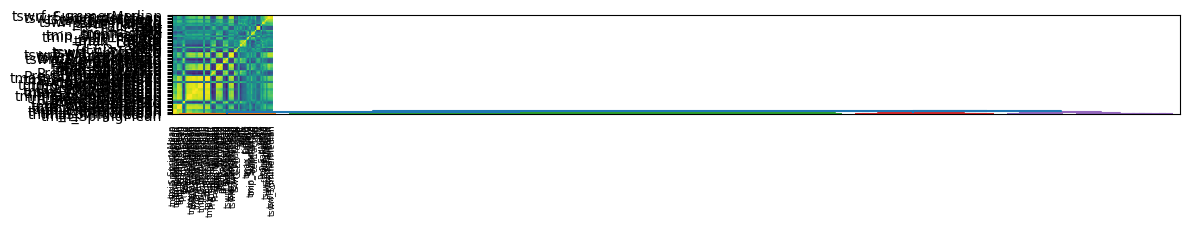

In [91]:
model_run(region_train_3, region_test_3, objective_list=biome_list_3)

Some evaluation of the model.

And now run the model whilst removing the medians

We dropped the features: ['tmax_SpringMedian', 'tmax_SummerMedian', 'tmax_FallMedian', 'tmax_WinterMedian', 'tswrf_SpringMedian', 'tswrf_SummerMedian', 'tswrf_FallMedian', 'tswrf_WinterMedian', 'tmin_SpringMedian', 'tmin_SummerMedian', 'tmin_FallMedian', 'tmin_WinterMedian', 'tmp_SpringMedian', 'tmp_SummerMedian', 'tmp_FallMedian', 'tmp_WinterMedian', 'Pre_SpringMedian', 'Pre_SummerMedian', 'Pre_FallMedian', 'Pre_WinterMedian']
length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9632 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.9919
Balanced accuracy of RandomForestClassifier on train data: 0.9912


---
 The confusion table

Truth,16,17
Predicted,,
16,477,6
17,1,383


,precision,recall,f1-score,support
16,0.987578,0.997908,0.992716,478.000000
17,0.997396,0.984576,0.990944,389.000000
accuracy,0.991926,0.991926,0.991926,0.991926
macro avg,0.992487,0.991242,0.991830,867.000000
weighted avg,0.991983,0.991926,0.991921,867.000000


---
 The feature importance

,importance
SoilR,0.143831
VegC,0.087635
NPP,0.069610
Pre_SpringMean,0.064470
tmp_FallMean,0.058189
Pre_WinterMean,0.048003
Pre_WinterStd,0.042217
tmin_FallMean,0.039417
tmp_SummerMean,0.034553
tswrf_WinterMean,0.031324


---

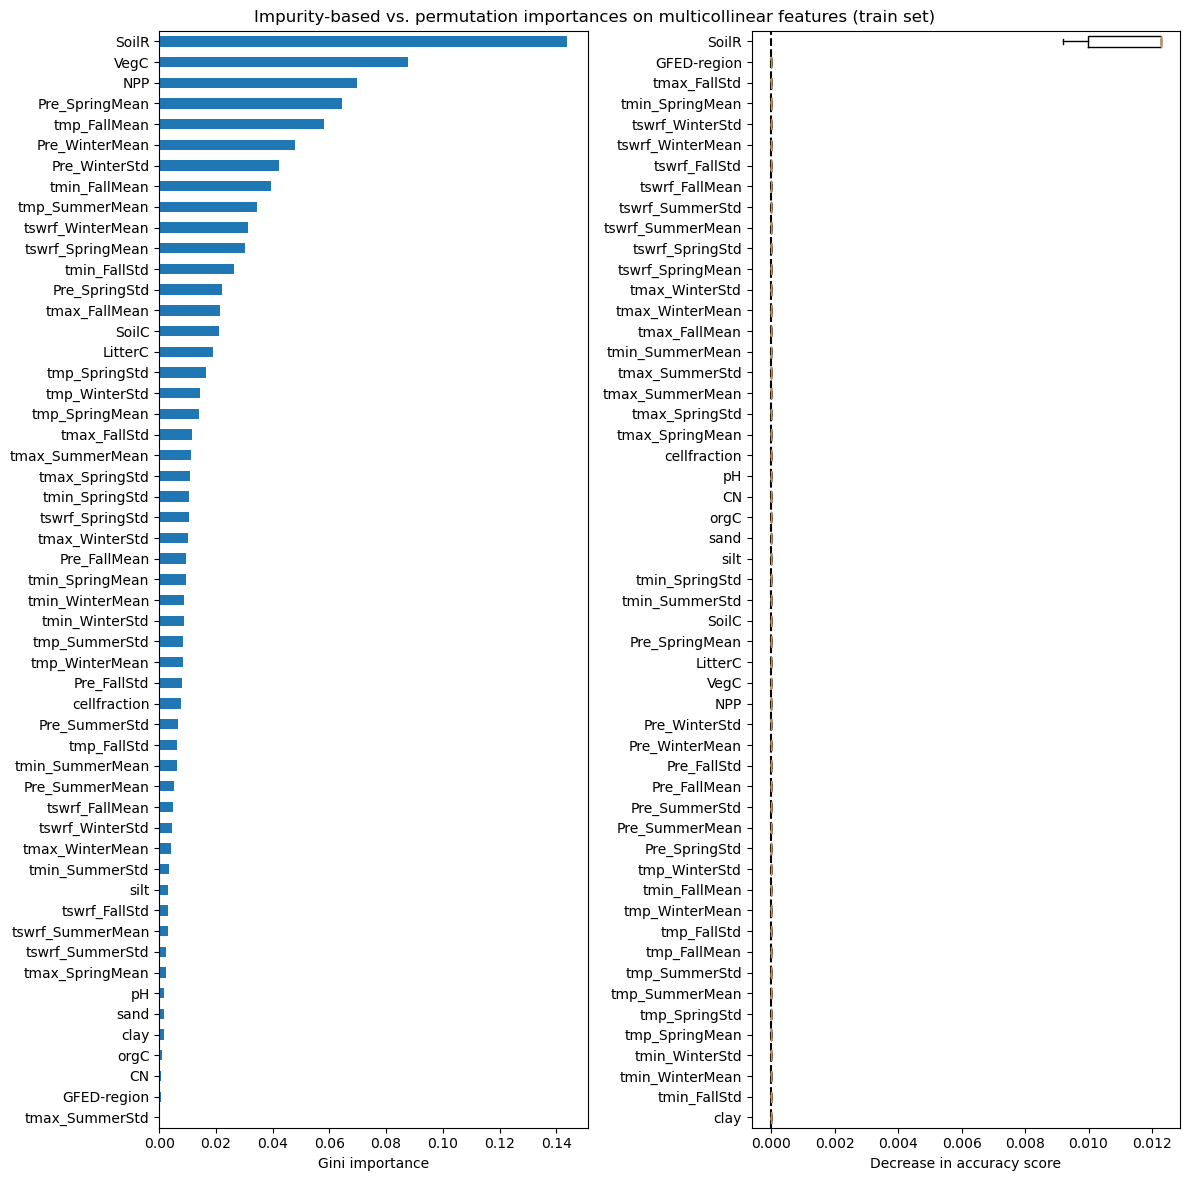

In [57]:
features_median = [feature_name for feature_name in list(data_index_2) if feature_name[-6:]=='Median']
print(f'We dropped the features: {features_median}')

model_run(region_train_3, region_test_3, objective_list=biome_list_3, drop_columns=features_median)

Let's see how important the weather is.

In [167]:
features_weather = [feature_name for feature_name in list(data_index_2) if \
                   re.search('Fall|Summer|Winter|Spring',feature_name)]
print(f'We dropped the features: {features_weather}')
display(Markdown('---'))

model_run(region_train_3, region_test_3, objective_list=biome_list_3, drop_columns=features_weather.copy())

We dropped the features: ['tmax_SpringMean', 'tmax_SpringMedian', 'tmax_SpringStd', 'tmax_SummerMean', 'tmax_SummerMedian', 'tmax_SummerStd', 'tmax_FallMean', 'tmax_FallMedian', 'tmax_FallStd', 'tmax_WinterMean', 'tmax_WinterMedian', 'tmax_WinterStd', 'tswrf_SpringMean', 'tswrf_SpringMedian', 'tswrf_SpringStd', 'tswrf_SummerMean', 'tswrf_SummerMedian', 'tswrf_SummerStd', 'tswrf_FallMean', 'tswrf_FallMedian', 'tswrf_FallStd', 'tswrf_WinterMean', 'tswrf_WinterMedian', 'tswrf_WinterStd', 'tmin_SpringMean', 'tmin_SpringMedian', 'tmin_SpringStd', 'tmin_SummerMean', 'tmin_SummerMedian', 'tmin_SummerStd', 'tmin_FallMean', 'tmin_FallMedian', 'tmin_FallStd', 'tmin_WinterMean', 'tmin_WinterMedian', 'tmin_WinterStd', 'tmp_SpringMean', 'tmp_SpringMedian', 'tmp_SpringStd', 'tmp_SummerMean', 'tmp_SummerMedian', 'tmp_SummerStd', 'tmp_FallMean', 'tmp_FallMedian', 'tmp_FallStd', 'tmp_WinterMean', 'tmp_WinterMedian', 'tmp_WinterStd', 'Pre_SpringMean', 'Pre_SpringMedian', 'Pre_SpringStd', 'Pre_SummerMean

---

length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9663 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.9931
Balanced accuracy of RandomForestClassifier on train data: 0.9925


---
 The confusion table

Truth,16,17
Predicted,,
16,477,5
17,1,384


,precision,recall,f1-score,support
16,0.989627,0.997908,0.993750,478.00000
17,0.997403,0.987147,0.992248,389.00000
accuracy,0.993080,0.993080,0.993080,0.99308
macro avg,0.993515,0.992527,0.992999,867.00000
weighted avg,0.993115,0.993080,0.993076,867.00000


---
 The feature importance

,importance
SoilR,0.318373
VegC,0.194957
NPP,0.183975
SoilC,0.078456
LitterC,0.076630
clay,0.036141
cellfraction,0.027651
sand,0.025204
pH,0.017084
silt,0.014798


---

What effect do the different seasons have?

In [168]:
seasons = ['Fall','Summer','Winter','Spring']
features_seasons = [[feature_name for feature_name in list(data_index_2) if \
                   re.search(season,feature_name)] for season in seasons]

for i,season in enumerate(seasons):
    print(f'Dropping season {season}')
    model_run(region_train_3, region_test_3, objective_list=biome_list_3, drop_columns=features_seasons[i])

Dropping season Fall
length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9632 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.9400
Balanced accuracy of RandomForestClassifier on train data: 0.9334


---
 The confusion table

Truth,16,17
Predicted,,
16,477,51
17,1,338


,precision,recall,f1-score,support
16,0.903409,0.997908,0.948310,478.000000
17,0.997050,0.868895,0.928571,389.000000
accuracy,0.940023,0.940023,0.940023,0.940023
macro avg,0.950230,0.933401,0.938441,867.000000
weighted avg,0.945423,0.940023,0.939454,867.000000


---
 The feature importance

,importance
SoilR,0.113081
NPP,0.075368
VegC,0.074045
Pre_WinterMean,0.069700
Pre_WinterMedian,0.064192
Pre_SpringMean,0.053945
Pre_SpringMedian,0.052056
Pre_WinterStd,0.037603
tswrf_SpringMean,0.033213
tswrf_WinterMean,0.031864


---

Dropping season Summer
length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9632 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.9308
Balanced accuracy of RandomForestClassifier on train data: 0.9234


---
 The confusion table

Truth,16,17
Predicted,,
16,476,58
17,2,331


,precision,recall,f1-score,support
16,0.891386,0.995816,0.940711,478.000000
17,0.993994,0.850900,0.916898,389.000000
accuracy,0.930796,0.930796,0.930796,0.930796
macro avg,0.942690,0.923358,0.928804,867.000000
weighted avg,0.937423,0.930796,0.930027,867.000000


---
 The feature importance

,importance
SoilR,0.115421
NPP,0.078965
Pre_WinterMean,0.078209
VegC,0.073566
Pre_WinterMedian,0.066785
Pre_SpringMean,0.053857
Pre_SpringMedian,0.046223
Pre_WinterStd,0.032143
tswrf_SpringMean,0.029890
tmin_FallMedian,0.028633


---

Dropping season Winter
length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9632 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.9769
Balanced accuracy of RandomForestClassifier on train data: 0.9745


---
 The confusion table

Truth,16,17
Predicted,,
16,477,19
17,1,370


,precision,recall,f1-score,support
16,0.961694,0.997908,0.979466,478.000000
17,0.997305,0.951157,0.973684,389.000000
accuracy,0.976932,0.976932,0.976932,0.976932
macro avg,0.979499,0.974532,0.976575,867.000000
weighted avg,0.977671,0.976932,0.976872,867.000000


---
 The feature importance

,importance
SoilR,0.110845
VegC,0.089777
NPP,0.075379
Pre_SpringMean,0.052803
Pre_SpringMedian,0.051670
tswrf_SpringMean,0.040491
tmp_SummerMean,0.036545
tmp_SummerMedian,0.034106
tmp_FallMedian,0.033158
tmin_SummerMean,0.031910


---

Dropping season Spring
length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9632 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.9781
Balanced accuracy of RandomForestClassifier on train data: 0.9758


---
 The confusion table

Truth,16,17
Predicted,,
16,477,18
17,1,371


,precision,recall,f1-score,support
16,0.963636,0.997908,0.980473,478.000000
17,0.997312,0.953728,0.975033,389.000000
accuracy,0.978085,0.978085,0.978085,0.978085
macro avg,0.980474,0.975818,0.977753,867.000000
weighted avg,0.978746,0.978085,0.978032,867.000000


---
 The feature importance

,importance
SoilR,0.120728
Pre_WinterMean,0.086957
VegC,0.081312
NPP,0.076829
Pre_WinterMedian,0.063743
Pre_WinterStd,0.045300
tmp_FallMedian,0.037575
tmin_FallStd,0.028709
tswrf_WinterMean,0.026362
SoilC,0.025530


---

Dropping autumn or summer had the biggest impact. Dropping spring and winter the least. Dropping the seasons does negatively effect our model. Now we test the different weather parameters.

In [105]:
weather_params = ['pre','tmp|tmin|tmax','tswrf']
features_weather_params = [[feature_name for feature_name in list(data_index_2) if \
                   re.search(weather_param,feature_name)] for weather_param in weather_params]

for i,weather_param in enumerate(weather_params):
    print(f'Dropping the weather parameters {weather_param}')
    model_run(region_train_3, region_test_3, objective_list=biome_list_3, drop_columns=features_weather_params[i].copy())

Dropping the weather parameters pre
length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9632 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.9850


---
 The confusion table

Truth,16,17
Predicted,,
16,477,12
17,1,377


,precision,recall,f1-score,support
16,0.975460,0.997908,0.986556,478.000000
17,0.997354,0.969152,0.983051,389.000000
accuracy,0.985006,0.985006,0.985006,0.985006
macro avg,0.986407,0.983530,0.984804,867.000000
weighted avg,0.985284,0.985006,0.984984,867.000000


---
 The feature importance

,importance
SoilR,0.119342
VegC,0.096762
tmp_FallMean,0.069502
Pre_SpringMedian,0.050491
NPP,0.046478
...,...
CN,0.000878
silt,0.000679
GFED-region,0.000266
orgC,0.000218


---

Dropping the weather parameters tmp|tmin|tmax
length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9632 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.9839


---
 The confusion table

Truth,16,17
Predicted,,
16,473,9
17,5,380


,precision,recall,f1-score,support
16,0.981328,0.989540,0.985417,478.000000
17,0.987013,0.976864,0.981912,389.000000
accuracy,0.983852,0.983852,0.983852,0.983852
macro avg,0.984170,0.983202,0.983664,867.000000
weighted avg,0.983879,0.983852,0.983844,867.000000


---
 The feature importance

,importance
SoilR,0.205801
NPP,0.094232
VegC,0.092806
Pre_WinterMean,0.077592
Pre_WinterMedian,0.061328
Pre_SpringMedian,0.051941
Pre_SpringMean,0.046326
Pre_SpringStd,0.039649
tswrf_WinterMean,0.036084
Pre_WinterStd,0.033487


---

Dropping the weather parameters tswrf
length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9662 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.9850


---
 The confusion table

Truth,16,17
Predicted,,
16,477,12
17,1,377


,precision,recall,f1-score,support
16,0.975460,0.997908,0.986556,478.000000
17,0.997354,0.969152,0.983051,389.000000
accuracy,0.985006,0.985006,0.985006,0.985006
macro avg,0.986407,0.983530,0.984804,867.000000
weighted avg,0.985284,0.985006,0.984984,867.000000


---
 The feature importance

,importance
SoilR,0.175704
NPP,0.083899
Pre_WinterMedian,0.046700
VegC,0.043503
Pre_WinterStd,0.042216
...,...
clay,0.000917
pH,0.000708
CN,0.000695
sand,0.000487


---

None of the weather parameters has a striking impact on performance. Now lets see if the model works only with weather data.

In [106]:
print(f'We only use the features: {features_weather}')
display(Markdown('---'))

model_run(region_train_3, region_test_3, objective_list=biome_list_3, use_columns=features_weather)

We only use the features: ['tmax_SpringMean', 'tmax_SpringMedian', 'tmax_SpringStd', 'tmax_SummerMean', 'tmax_SummerMedian', 'tmax_SummerStd', 'tmax_FallMean', 'tmax_FallMedian', 'tmax_FallStd', 'tmax_WinterMean', 'tmax_WinterMedian', 'tmax_WinterStd', 'tswrf_SpringMean', 'tswrf_SpringMedian', 'tswrf_SpringStd', 'tswrf_SummerMean', 'tswrf_SummerMedian', 'tswrf_SummerStd', 'tswrf_FallMean', 'tswrf_FallMedian', 'tswrf_FallStd', 'tswrf_WinterMean', 'tswrf_WinterMedian', 'tswrf_WinterStd', 'tmin_SpringMean', 'tmin_SpringMedian', 'tmin_SpringStd', 'tmin_SummerMean', 'tmin_SummerMedian', 'tmin_SummerStd', 'tmin_FallMean', 'tmin_FallMedian', 'tmin_FallStd', 'tmin_WinterMean', 'tmin_WinterMedian', 'tmin_WinterStd', 'tmp_SpringMean', 'tmp_SpringMedian', 'tmp_SpringStd', 'tmp_SummerMean', 'tmp_SummerMedian', 'tmp_SummerStd', 'tmp_FallMean', 'tmp_FallMedian', 'tmp_FallStd', 'tmp_WinterMean', 'tmp_WinterMedian', 'tmp_WinterStd', 'Pre_SpringMean', 'Pre_SpringMedian', 'Pre_SpringStd', 'Pre_SummerMea

---

length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9509 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.5502


---
 The confusion table

Truth,16,17
Predicted,,
16,477,389
17,1,0


,precision,recall,f1-score,support
16,0.550808,0.997908,0.709821,478.000000
17,0.000000,0.000000,NaN,389.000000
accuracy,0.550173,0.550173,0.550173,0.550173
macro avg,0.275404,0.498954,0.709821,867.000000
weighted avg,0.303675,0.550173,0.709821,867.000000


---
 The feature importance

,importance
Pre_SpringMedian,0.071748
Pre_WinterMean,0.066330
tmin_FallMedian,0.055103
Pre_SpringMean,0.054281
Pre_WinterStd,0.053840
tmp_FallMean,0.048556
tmp_FallMedian,0.040753
tswrf_WinterMedian,0.038230
Pre_WinterMedian,0.037585
tmp_SummerMedian,0.036044


---

It performs terribly as would be expected if one removed the most important parameters.

## Section 4: Multiclass classification

Because of the significant negative impact on the learning outcome by choosing regions at very different latitudes we chose as regions
- for training: Canada
- for testing: Russia

In [ ]:
biome_list_3 = [17,16] # our chosen biomes
relevant_data = data_index_2.loc[data_index_2['Biome_obs'].isin(biome_list_3)]
relevant_data = relevant_data[~(relevant_data.isna().any(axis=1))] # delete rows with NaN

plot_statistics(relevant_data, name_data = 'relevant_data')

In [107]:
region_train_4 = data_index_2['Pan_2007'] == 'Canada'
region_test_4 = data_index_2['Pan_2007'] == 'Russia'

# plot the data
data1 = relevant_data.loc[region_train_4] 
data2 = relevant_data.loc[region_test_4]

data = pd.concat([data1,data2])
plot_statistics(data, name_data = 'Section4Canada_Russia')

In [170]:
print(region_train_4)  #?????????????????

0        False
1        False
2        False
3        False
4        False
         ...  
59186    False
59187    False
59188    False
59189    False
59190    False
Name: Pan_2007, Length: 59190, dtype: bool


And now we run the simulation

In [108]:
model_run(region_train_4, region_test_4)

length of training data: 6499
length of testing data: 11695
Max Depth:  5
Max Trees:  10
Min Leafs:  1
Max CV:  0.7777777777777778
Accuracy of RandomForestClassifier on train data: 0.9757
Accuracy RandomForestClassifier on cross validation: 0.9771 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.8367


---
 The confusion table

Truth,1,2,3,5,12,13,14,15,17,18
Predicted,,,,,,,,,,
1,548,2,0,0,0,0,0,0,0,5
2,717,4082,44,284,0,87,6,1,0,16
3,0,0,0,0,0,0,0,0,0,0
5,0,15,6,147,26,0,0,127,0,0
12,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,1147,4


,precision,recall,f1-score,support
1,0.987387,0.420245,0.589564,1304.000000
2,0.779454,0.896749,0.833997,4552.000000
3,NaN,0.000000,NaN,50.000000
5,0.457944,0.341067,0.390957,431.000000
12,NaN,0.000000,NaN,26.000000
13,NaN,0.000000,NaN,114.000000
14,NaN,0.000000,NaN,41.000000
15,NaN,0.000000,NaN,128.000000
17,0.996525,0.986242,0.991357,1163.000000
18,0.871361,0.993567,0.928460,3886.000000


---
 The feature importance

,importance
VegC,0.168949
LitterC,0.120310
NPP,0.103247
tmp_FallMean,0.085756
tmax_FallMean,0.076051
...,...
Pre_SpringMean,0.000000
tswrf_SpringStd,0.000000
tswrf_SummerStd,0.000000
silt,0.000000


---

This is relatively bad performance. Fiddling with the hyperparameters changes a lot though the
hyperparameter optimisation is far from optimal. Let's see how good it is.

In [109]:
model_run(region_train_4, region_test_4, hyperparameter_tuning=True)

length of training data: 6499
length of testing data: 11695
Max Depth:  5
Max Trees:  20
Min Leafs:  1
Max CV:  1.0
Accuracy of RandomForestClassifier on train data: 0.9788
Accuracy RandomForestClassifier on cross validation: 0.9726 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.8669


---
 The confusion table

Truth,1,2,3,5,12,13,14,15,17,18
Predicted,,,,,,,,,,
1,502,0,0,0,0,0,0,0,0,1
2,621,4392,44,208,1,46,1,17,0,19
3,0,0,0,0,0,0,0,0,0,0
5,0,12,6,223,23,0,0,111,0,0
12,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,2,10,7,0,0,0
14,0,0,0,0,0,0,1,0,0,0
15,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,1147,3


,precision,recall,f1-score,support
1,0.998012,0.384969,0.555617,1304.000000
2,0.821088,0.964851,0.887183,4552.000000
3,NaN,0.000000,NaN,50.000000
5,0.594667,0.517401,0.553350,431.000000
12,NaN,0.000000,NaN,26.000000
13,0.526316,0.087719,0.150376,114.000000
14,1.000000,0.024390,0.047619,41.000000
15,NaN,0.000000,NaN,128.000000
17,0.997391,0.986242,0.991786,1163.000000
18,0.898790,0.994081,0.944037,3886.000000


---
 The feature importance

,importance
VegC,0.147716
tmax_FallMean,0.115718
tmin_SpringMean,0.095818
NPP,0.093172
SoilC,0.082956
LitterC,0.057366
SoilR,0.057135
tmp_FallMean,0.053599
tmp_SummerMean,0.049817
tswrf_FallMean,0.035229


---

It's not too good in this case. But when we were previously comparing Africa with China fiddling with the parameters actually did improve things. In the following we will thus disable the hyperparameter tuning. Let's see if things improve if we drop the features with medians.

In [110]:
model_run(region_train_4, region_test_4, drop_columns=features_median)

length of training data: 6499
length of testing data: 11695
Max Depth:  5
Max Trees:  10
Min Leafs:  1
Max CV:  0.8333333333333334
Accuracy of RandomForestClassifier on train data: 0.9640
Accuracy RandomForestClassifier on cross validation: 0.9618 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.8133


---
 The confusion table

Truth,1,2,3,5,12,13,14,15,17,18
Predicted,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0
2,1281,4509,50,421,19,4,0,120,0,35
3,0,0,0,0,0,0,0,0,0,0
5,0,0,0,8,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,1146,3


,precision,recall,f1-score,support
1,NaN,0.000000,NaN,1304.000000
2,0.700264,0.990554,0.820489,4552.000000
3,NaN,0.000000,NaN,50.000000
5,1.000000,0.018561,0.036446,431.000000
12,NaN,0.000000,NaN,26.000000
13,NaN,0.000000,NaN,114.000000
14,NaN,0.000000,NaN,41.000000
15,NaN,0.000000,NaN,128.000000
17,0.997389,0.985383,0.991349,1163.000000
18,0.938766,0.990221,0.963807,3886.000000


---
 The feature importance

,importance
VegC,0.236430
LitterC,0.219050
NPP,0.203639
SoilR,0.155089
SoilC,0.097254
silt,0.033085
CN,0.018500
sand,0.016106
orgC,0.009511
pH,0.006360


---

That did not make much of a difference. Let's see what happens if we remove the entire weather data.

In [111]:
model_run(region_train_4, region_test_4, drop_columns=features_weather)

Dropping season Fall
length of training data: 6499
length of testing data: 11695
Max Depth:  5
Max Trees:  10
Min Leafs:  1
Max CV:  0.8333333333333334
Accuracy of RandomForestClassifier on train data: 0.9806
Accuracy RandomForestClassifier on cross validation: 0.9791 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.8939


---
 The confusion table

Truth,1,2,3,5,12,13,14,15,17,18
Predicted,,,,,,,,,,
1,873,0,0,0,0,2,0,0,0,11
2,353,4436,46,298,1,36,8,5,0,3
3,0,1,0,1,0,0,0,0,0,0
5,0,5,4,132,25,0,0,123,0,0
12,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,1,0,0,0,0
15,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,1146,5


,precision,recall,f1-score,support
1,0.985327,0.669479,0.797260,1304.000000
2,0.855380,0.974517,0.911070,4552.000000
3,0.000000,0.000000,NaN,50.000000
5,0.456747,0.306265,0.366667,431.000000
12,NaN,0.000000,NaN,26.000000
13,NaN,0.000000,NaN,114.000000
14,0.000000,0.000000,NaN,41.000000
15,NaN,0.000000,NaN,128.000000
17,0.995656,0.985383,0.990493,1163.000000
18,0.925120,0.995111,0.958840,3886.000000


---
 The feature importance

,importance
VegC,0.328304
tmin_SummerMedian,0.096857
LitterC,0.088280
SoilR,0.083679
tmax_SummerMedian,0.068598
tmax_SummerMean,0.045665
tmax_SpringMean,0.043534
SoilC,0.039992
tmin_SummerMean,0.034691
tmin_SpringStd,0.028409


---

Dropping season Summer
length of training data: 6499
length of testing data: 11695
Max Depth:  5
Max Trees:  30
Min Leafs:  1
Max CV:  0.9444444444444445
Accuracy of RandomForestClassifier on train data: 0.9814
Accuracy RandomForestClassifier on cross validation: 0.9758 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.8814


---
 The confusion table

Truth,1,2,3,5,12,13,14,15,17,18
Predicted,,,,,,,,,,
1,689,0,0,0,0,0,0,0,0,9
2,564,4474,47,306,1,37,0,17,0,12
3,0,0,0,0,0,0,0,0,0,0
5,0,3,3,125,22,0,0,111,0,0
12,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,6,0,0,0,0
14,0,0,0,0,3,0,6,0,0,0
15,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,1146,3


,precision,recall,f1-score,support
1,0.987106,0.528374,0.688312,1304.000000
2,0.819714,0.982865,0.893906,4552.000000
3,NaN,0.000000,NaN,50.000000
5,0.473485,0.290023,0.359712,431.000000
12,NaN,0.000000,NaN,26.000000
13,1.000000,0.052632,0.100000,114.000000
14,0.666667,0.146341,0.240000,41.000000
15,NaN,0.000000,NaN,128.000000
17,0.997389,0.985383,0.991349,1163.000000
18,0.939431,0.993824,0.965862,3886.000000


---
 The feature importance

,importance
VegC,0.195188
NPP,0.100937
tmp_FallMedian,0.075225
tmp_FallMean,0.074580
LitterC,0.066556
SoilR,0.065360
tmax_FallMedian,0.048845
tmax_SpringMean,0.045392
tmax_FallMean,0.035277
SoilC,0.034742


---

Dropping season Winter
length of training data: 6499
length of testing data: 11695
Max Depth:  5
Max Trees:  30
Min Leafs:  1
Max CV:  1.0
Accuracy of RandomForestClassifier on train data: 0.9791
Accuracy RandomForestClassifier on cross validation: 0.9740 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.8441


---
 The confusion table

Truth,1,2,3,5,12,13,14,15,17,18
Predicted,,,,,,,,,,
1,451,0,0,0,0,0,0,0,0,1
2,785,4377,46,400,26,49,8,125,0,14
3,0,0,0,0,0,0,0,0,0,0
5,0,5,4,31,0,0,0,3,0,0
12,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,1,0,0,0,0
15,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,1146,4


,precision,recall,f1-score,support
1,0.997788,0.345859,0.513667,1304.000000
2,0.750772,0.961555,0.843190,4552.000000
3,NaN,0.000000,NaN,50.000000
5,0.720930,0.071926,0.130802,431.000000
12,NaN,0.000000,NaN,26.000000
13,NaN,0.000000,NaN,114.000000
14,0.000000,0.000000,NaN,41.000000
15,NaN,0.000000,NaN,128.000000
17,0.996522,0.985383,0.990921,1163.000000
18,0.916568,0.995111,0.954226,3886.000000


---
 The feature importance

,importance
VegC,0.181424
NPP,0.088954
tmin_SummerMedian,0.087187
tmp_SummerMedian,0.068135
tmax_FallMedian,0.060042
LitterC,0.049273
tmp_FallMedian,0.045817
SoilR,0.039081
tmp_FallMean,0.033214
tmax_FallMean,0.032212


---

Dropping season Spring
length of training data: 6499
length of testing data: 11695
Max Depth:  5
Max Trees:  10
Min Leafs:  1
Max CV:  0.8333333333333334
Accuracy of RandomForestClassifier on train data: 0.9834
Accuracy RandomForestClassifier on cross validation: 0.9777 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.9057


---
 The confusion table

Truth,1,2,3,5,12,13,14,15,17,18
Predicted,,,,,,,,,,
1,830,6,0,0,0,0,0,0,0,12
2,449,4476,43,202,0,5,1,1,0,6
3,0,0,0,0,0,0,0,0,0,0
5,0,19,7,229,23,0,0,127,0,0
12,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,22,2,0,0,0
14,0,0,0,0,3,11,25,0,0,0
15,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,1146,4


,precision,recall,f1-score,support
1,0.978774,0.636503,0.771375,1304.000000
2,0.863593,0.983304,0.919569,4552.000000
3,NaN,0.000000,NaN,50.000000
5,0.565432,0.531323,0.547847,431.000000
12,NaN,0.000000,NaN,26.000000
13,0.916667,0.192982,0.318841,114.000000
14,0.641026,0.609756,0.625000,41.000000
15,NaN,0.000000,NaN,128.000000
17,0.996522,0.985383,0.990921,1163.000000
18,0.955017,0.994339,0.974281,3886.000000


---
 The feature importance

,importance
VegC,0.346871
LitterC,0.095882
tmin_SummerMean,0.068097
SoilC,0.056216
SoilR,0.051994
tmin_SummerMedian,0.046834
tmax_FallMean,0.046738
tmax_SummerMean,0.044215
tmp_FallMean,0.043819
tmax_FallMedian,0.033604


---

Apparently the weather is important, but not very. Let's see what effect the different seasons have

In [112]:
for i,season in enumerate(seasons):
    print(f'Dropping season {season}')
    model_run(region_train_4, region_test_4, drop_columns=features_seasons[i])

['tmax_SpringMean', 'tmax_SpringMedian', 'tmax_SpringStd', 'tmax_SummerMean', 'tmax_SummerMedian', 'tmax_SummerStd', 'tmax_FallMean', 'tmax_FallMedian', 'tmax_FallStd', 'tmax_WinterMean', 'tmax_WinterMedian', 'tmax_WinterStd', 'tswrf_SpringMean', 'tswrf_SpringMedian', 'tswrf_SpringStd', 'tswrf_SummerMean', 'tswrf_SummerMedian', 'tswrf_SummerStd', 'tswrf_FallMean', 'tswrf_FallMedian', 'tswrf_FallStd', 'tswrf_WinterMean', 'tswrf_WinterMedian', 'tswrf_WinterStd', 'tmin_SpringMean', 'tmin_SpringMedian', 'tmin_SpringStd', 'tmin_SummerMean', 'tmin_SummerMedian', 'tmin_SummerStd', 'tmin_FallMean', 'tmin_FallMedian', 'tmin_FallStd', 'tmin_WinterMean', 'tmin_WinterMedian', 'tmin_WinterStd', 'tmp_SpringMean', 'tmp_SpringMedian', 'tmp_SpringStd', 'tmp_SummerMean', 'tmp_SummerMedian', 'tmp_SummerStd', 'tmp_FallMean', 'tmp_FallMedian', 'tmp_FallStd', 'tmp_WinterMean', 'tmp_WinterMedian', 'tmp_WinterStd', 'Pre_SpringMean', 'Pre_SpringMedian', 'Pre_SpringStd', 'Pre_SummerMean', 'Pre_SummerMedian', 'P

ValueError: 
All the 192 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
192 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\annar\anaconda3\envs\RoutineEnvironment\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\annar\anaconda3\envs\RoutineEnvironment\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\annar\anaconda3\envs\RoutineEnvironment\lib\site-packages\sklearn\ensemble\_forest.py", line 348, in fit
    X, y = self._validate_data(
  File "C:\Users\annar\anaconda3\envs\RoutineEnvironment\lib\site-packages\sklearn\base.py", line 621, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\annar\anaconda3\envs\RoutineEnvironment\lib\site-packages\sklearn\utils\validation.py", line 1147, in check_X_y
    X = check_array(
  File "C:\Users\annar\anaconda3\envs\RoutineEnvironment\lib\site-packages\sklearn\utils\validation.py", line 917, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "C:\Users\annar\anaconda3\envs\RoutineEnvironment\lib\site-packages\sklearn\utils\_array_api.py", line 380, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "C:\Users\annar\anaconda3\envs\RoutineEnvironment\lib\site-packages\pandas\core\generic.py", line 2070, in __array__
    return np.asarray(self._values, dtype=dtype)
ValueError: could not convert string to float: 'Canada'


We see that dropping fall decreased the performance the most whilst dropping the summer actually increased performance slightly. Let's see what happens if we use only weather data.

In [ ]:
print(features_weather)
model_run(region_train_4, region_test_4, use_columns=features_weather)

Turn's out that using only weather to classify biomes does not really go well. Let's see if the model works better at classifying 'Biome_Cmax'.

In [113]:
model_run(region_train_4, region_test_4, objective='Biome_Cmax')

length of training data: 6499
length of testing data: 11518
Max Depth:  5
Max Trees:  10
Min Leafs:  1
Max CV:  1.0
Accuracy of RandomForestClassifier on train data: 0.9568
Accuracy RandomForestClassifier on cross validation: 0.9481 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.7970


---
 The confusion table

Truth,1,2,3,5,11,13
Predicted,,,,,,
1,3609,665,934,374,54,0
2,9,8,0,1,0,0
3,0,0,229,0,1,0
5,3,1,0,256,0,0
11,75,11,190,0,4968,9
13,0,0,0,0,11,110


,precision,recall,f1-score,support
1,0.640348,0.976461,0.773468,3696.000000
2,0.444444,0.011679,0.022760,685.000000
3,0.995652,0.169254,0.289324,1353.000000
5,0.984615,0.405705,0.574635,631.000000
11,0.945745,0.986889,0.965879,5034.000000
13,0.909091,0.924370,0.916667,119.000000
accuracy,0.797013,0.797013,0.797013,0.797013
macro avg,0.819983,0.579060,0.590455,11518.000000
weighted avg,0.825546,0.797013,0.746631,11518.000000


---
 The feature importance

,importance
VegC,0.230417
tmp_FallMean,0.081624
LitterC,0.081326
SoilR,0.063740
NPP,0.050621
...,...
Pre_FallStd,0.000000
Pre_SummerMedian,0.000000
tswrf_SummerMedian,0.000000
silt,0.000000


---

That is quite decent performance though not as good as with biome_obs.

## Section 4.6

Test the model trained with 'Biome_Cmax' on 'Biome_obs'.

In [114]:
model_run(region_train_4, region_test_4, objective='Biome_Cmax', objective_test='Biome_obs')

length of training data: 6499
length of testing data: 6451
Max Depth:  5
Max Trees:  30
Min Leafs:  1
Max CV:  0.6111111111111112
Accuracy of RandomForestClassifier on train data: 0.9588
Accuracy RandomForestClassifier on cross validation: 0.9491 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.1848


---
 The confusion table

Truth,1,2,3,5,11,13
Predicted,,,,,,
1,823,4395,36,74,0,41
2,0,12,1,0,0,0
3,185,0,0,0,0,0
5,0,38,13,357,0,0
11,296,107,0,0,0,73
13,0,0,0,0,0,0


,precision,recall,f1-score,support
1,0.153287,0.631135,0.246666,1304.000000
2,0.923077,0.002636,0.005257,4552.000000
3,0.000000,0.000000,NaN,50.000000
5,0.875000,0.828306,0.851013,431.000000
11,0.000000,NaN,NaN,0.000000
13,NaN,0.000000,NaN,114.000000
accuracy,0.184778,0.184778,0.184778,0.184778
macro avg,0.390273,0.292415,0.367645,6451.000000
weighted avg,0.754120,0.184778,0.113308,6451.000000


---
 The feature importance

,importance
VegC,0.199769
SoilR,0.093334
tmp_FallMean,0.079289
tmin_SummerMedian,0.074344
LitterC,0.046464
...,...
silt,0.000000
tswrf_SummerMedian,0.000000
cellfraction,0.000000
CN,0.000000


---

Who would have thought? The model performs as badly as an antigen test measuring temperature. Now test the model trained on 'Biome_obs' on 'Biome_Cmax' (and expect a similar result).

In [115]:
model_run(region_train_4, region_test_4, objective='Biome_obs', objective_test='Biome_Cmax')

length of training data: 6499
length of testing data: 11518
Max Depth:  5
Max Trees:  40
Min Leafs:  1
Max CV:  0.7222222222222223
Accuracy of RandomForestClassifier on train data: 0.9765
Accuracy RandomForestClassifier on cross validation: 0.9732 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.0817


---
 The confusion table

Truth,1,2,3,5,11,13,17,18
Predicted,,,,,,,,
1,0,0,568,0,0,0,0,0
2,3403,662,679,352,67,0,0,0
3,0,0,0,0,0,0,0,0
5,3,0,0,279,0,0,0,0
11,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0
17,0,0,0,0,1031,119,0,0
18,290,23,106,0,3936,0,0,0


,precision,recall,f1-score,support
1,0.000000,0.000000,NaN,3696.000000
2,0.128220,0.966423,0.226402,685.000000
3,NaN,0.000000,NaN,1353.000000
5,0.989362,0.442155,0.611172,631.000000
11,NaN,0.000000,NaN,5034.000000
13,NaN,0.000000,NaN,119.000000
17,0.000000,NaN,NaN,0.000000
18,0.000000,NaN,NaN,0.000000
accuracy,0.081698,0.081698,0.081698,0.081698
macro avg,0.223516,0.234763,0.418787,11518.000000


---
 The feature importance

,importance
VegC,0.152808
SoilR,0.090176
NPP,0.080091
LitterC,0.079727
tmp_FallMean,0.068090
...,...
CN,0.000069
tmax_FallStd,0.000039
cellfraction,0.000034
silt,0.000000


---

... and the result is just as bad. What a surprise. Now compare our model with LPJ-Guess output

In [116]:
for objective in ['Biome_obs','Biome_Cmax']:
    print(f'Comparing LPJ-Guess with our model for the parameter {objective}')
    model_run(region_train_4, region_test_4, objective=objective, objective_test=f'LPJ_{objective}')

Comparing LPJ-Guess with our model for the parameter Biome_obs



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


length of training data: 6499
length of testing data: 9135
Max Depth:  5
Max Trees:  20
Min Leafs:  1
Max CV:  1.0
Accuracy of RandomForestClassifier on train data: 0.9820
Accuracy RandomForestClassifier on cross validation: 0.9775 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.1779


---
 The confusion table

Truth,1,2,3,5,11,12,13,14,15,16,17,18
Predicted,,,,,,,,,,,,
1,13,111,12,17,11,21,8,35,24,28,50,55
2,124,1052,66,397,91,340,30,378,287,461,587,519
3,0,0,0,0,0,0,0,0,0,0,0,0
5,7,53,5,19,6,18,1,14,16,25,32,29
11,0,0,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,0,0
13,0,2,0,0,0,1,0,1,0,1,0,1
14,0,0,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0,0,0,0,0,0


,precision,recall,f1-score,support
1,0.033766,0.048872,0.039939,266.000000
2,0.242844,0.468597,0.319903,2245.000000
3,NaN,0.000000,NaN,143.000000
5,0.084444,0.024934,0.038501,762.000000
11,NaN,0.000000,NaN,215.000000
12,NaN,0.000000,NaN,697.000000
13,0.000000,0.000000,NaN,77.000000
14,NaN,0.000000,NaN,768.000000
15,NaN,0.000000,NaN,613.000000
16,NaN,0.000000,NaN,925.000000


---
 The feature importance

,importance
VegC,0.216175
tmp_FallMean,0.088438
NPP,0.080506
LitterC,0.061301
SoilR,0.059909
...,...
Pre_SpringMean,0.000025
silt,0.000000
Pre_SpringMedian,0.000000
CN,0.000000


---

Comparing LPJ-Guess with our model for the parameter Biome_Cmax
length of training data: 6499
length of testing data: 6564



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Max Depth:  5
Max Trees:  30
Min Leafs:  1
Max CV:  0.8333333333333334
Accuracy of RandomForestClassifier on train data: 0.9588
Accuracy RandomForestClassifier on cross validation: 0.9491 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.2972


---
 The confusion table

Truth,1,2,3,5,11,13
Predicted,,,,,,
1,914,177,134,728,950,172
2,0,1,0,2,3,1
3,39,4,6,29,31,3
5,78,18,12,71,79,10
11,924,176,129,679,951,178
13,24,1,2,14,16,8


,precision,recall,f1-score,support
1,0.297236,0.461849,0.361694,1979.000000
2,0.142857,0.002653,0.005208,377.000000
3,0.053571,0.021201,0.030380,283.000000
5,0.264925,0.046619,0.079285,1523.000000
11,0.313138,0.468473,0.375370,2030.000000
13,0.123077,0.021505,0.036613,372.000000
accuracy,0.297227,0.297227,0.297227,0.297227
macro avg,0.199134,0.170383,0.148092,6564.000000
weighted avg,0.265415,0.297227,0.247216,6564.000000


---
 The feature importance

,importance
VegC,0.199769
SoilR,0.093334
tmp_FallMean,0.079289
tmin_SummerMedian,0.074344
LitterC,0.046464
...,...
silt,0.000000
tswrf_SummerMedian,0.000000
cellfraction,0.000000
CN,0.000000


---

Who would have thought that our model works badly in this case (duh)?

## Section 5: Regression 

In this part we creatively use the same test and validation set as in part 4

In [ ]:
region_train_5 = region_train_4
region_test_5 = region_test_4

In [86]:
# plot the data
data1 = data_index_2.loc[region_train_5] 
data2 = data_index_2.loc[region_test_5]

data = pd.concat([data1,data2])
plot_statistics(data, name_data = 'Section5Canada_Russia')

And we run the model.

length of training data: 6499
length of testing data: 11696
Accuracy of RandomForestRegressor on train data: 0.9997
Accuracy of RandomForestRegressor on test data: 0.9909
MSE for training data 0.00035548980367647033
MSE (with sktfct) for test  data 0.00035548980367647033
sqrt(MSE) for test data 0.018854437241044093
max error for test data 0.0920200000000001
mean abs error for test data 0.012770376196990422
mean abs oercentage error for test data 19610835244.75238


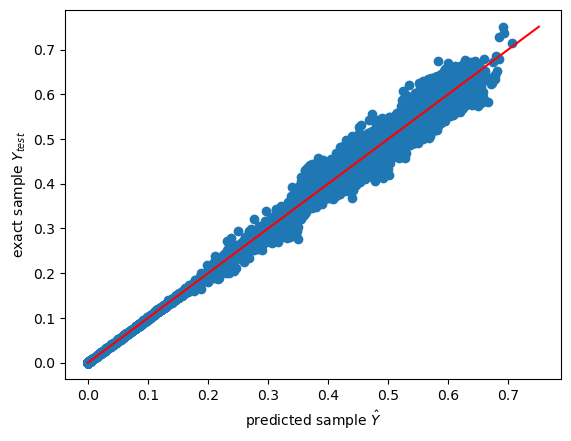

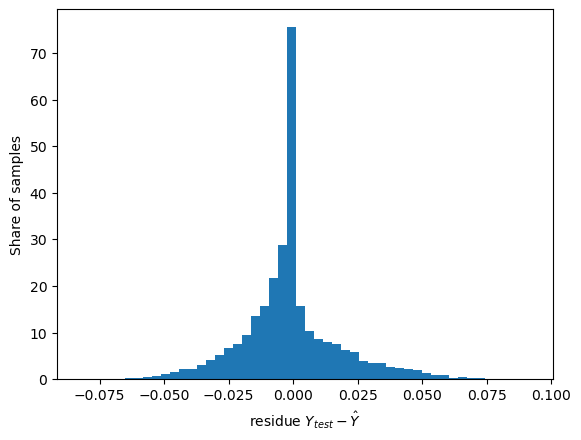

In [91]:
model_run(region_train_5, region_test_5, objective='NPP', continuous_Y=True)

A pretty decent outcome. Let's see how it behaves with 'VegC'.

length of training data: 6499
length of testing data: 11696
Accuracy of RandomForestRegressor on train data: 0.9923
Accuracy of RandomForestRegressor on test data: 0.8144
MSE for training data 1.3299234031000686


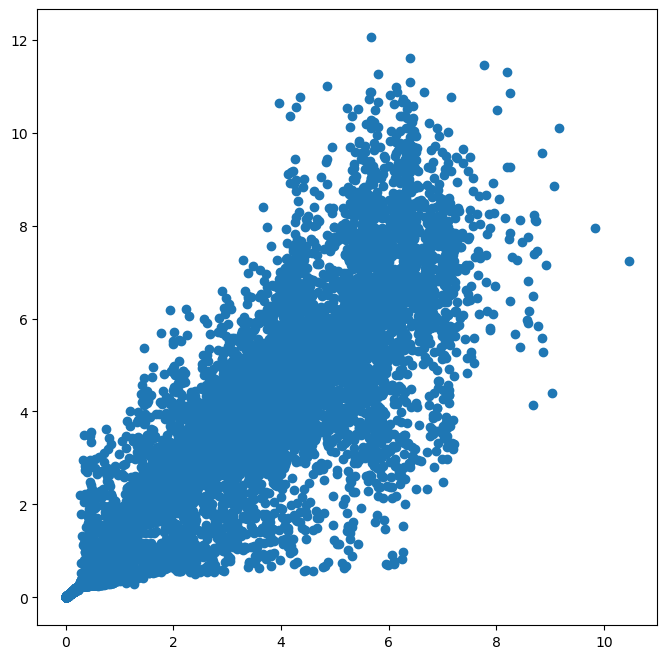

In [119]:
model_run(region_train_5, region_test_5, objective='VegC', continuous_Y=True)

'VegC' seems to perform worse. We analyse the importance of the weather on the prediction.

length of training data: 6499
length of testing data: 11696
Accuracy of RandomForestRegressor on train data: 0.9996
Accuracy of RandomForestRegressor on test data: 0.9920
MSE for training data 0.0003115149855185536


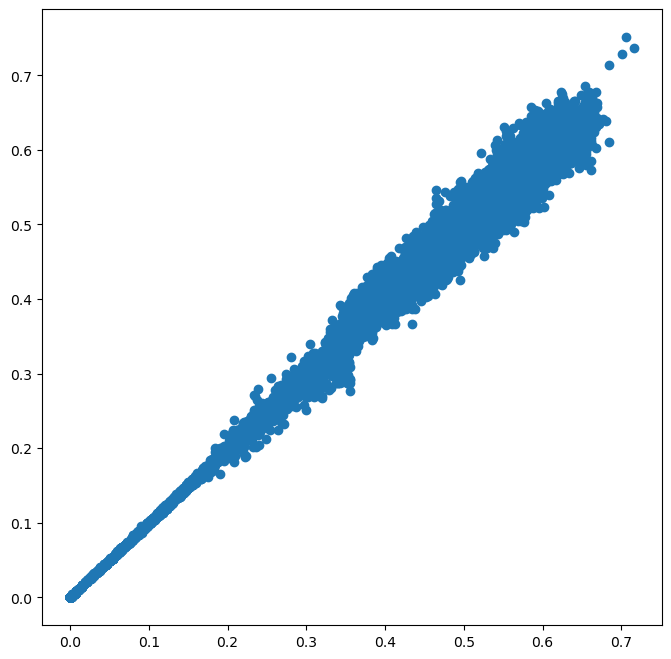

In [120]:
model_run(region_train_5, region_test_5, objective='NPP', continuous_Y=True, drop_columns=features_weather)

## Section 5.3
We compare the model with the LPJ_Guess output

Comparing LPJ-Guess with our model for the parameter NPP
length of training data: 6499
length of testing data: 11696
Accuracy of RandomForestRegressor on train data: 0.8472
Accuracy of RandomForestRegressor on test data: -0.5400
MSE for training data 0.1508477222611833
Comparing LPJ-Guess with our model for the parameter VegC
length of training data: 6499
length of testing data: 11696
Accuracy of RandomForestRegressor on train data: 0.8494
Accuracy of RandomForestRegressor on test data: -2.2124
MSE for training data 108.71702797892677


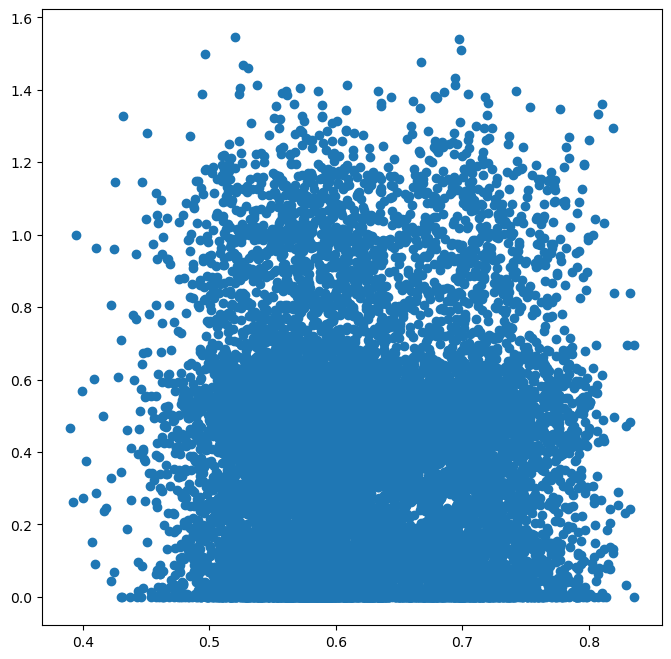

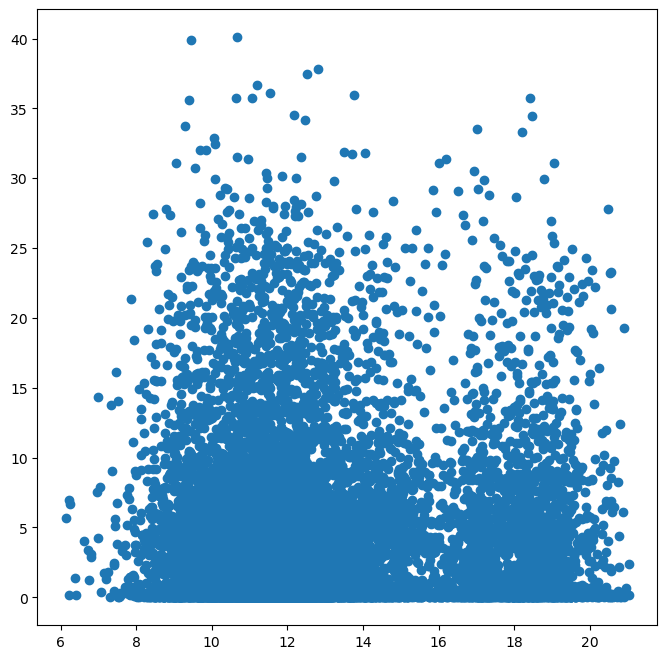

In [121]:
for objective in ['NPP','VegC']:
    print(f'Comparing LPJ-Guess with our model for the parameter {objective}')
    model_run(region_train_5, region_test_5, objective=objective, continuous_Y=True, objective_test=f'LPJ_{objective}')